<h3>Introduction.</h3>
<p>The goal of the notebook is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.In our quest we will be learning how to use Random forest. </p>

In [1]:
%load_ext autoreload 
#  reloads modules automatically before entering 
# the execution of code typed at the IPython prompt.
%autoreload 2

%matplotlib inline 
# draw the plots in the notebook

In [2]:
# importing the libraries we're going to be using.
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

We can create a variable PATH for where our project files such as csv file will be stored to make our work easier. The PATH will be different based on where your files are.

In [3]:
PATH = "/media/muoki/data/documents/code_training/portfolio/DataScienceProjects/fastai_Intro_ml/"

<h4>Loading the data.</h4>
<p>We will be using pandas to load the data we specify the column with dates while loading </p>

In [4]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

KeyboardInterrupt: 

if we view the columns in the dataframe it will trancate some due to the large number 

In [ ]:
df_raw.head(2)

To solve the issue above we write a function that shpws a maximum of 1000 row and column entries.

In [ ]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

we can now view the last 5 entries with all their columns it will be easier to view them if we transpose.

In [ ]:
display_all(df_raw.tail().T)

We can get a summary of the dataframe

In [ ]:
display_all(df_raw.describe(include='all').T)

The meteric used to evaluate the model is RMSLE (root mean squared log error) between the actual and predicted auction prices we need to get the logs of the dependent variable.

In [ ]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

<h4>Initial Processing</h4>
<p>At this point we can't run the algorithm as some of the columns are categorical data eg Medium, high, low . We also need to take care of the dates and split it to get vital info like was it end month etc</p>

In [ ]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

The categorical variables are currently stored as strings. We need to convert them into pandas categories

In [ ]:
?train_cats

In [ ]:
train_cats(df_raw)

A column such as UsageBand we can reorder the category types

In [ ]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [ ]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

Before we can start training our model we need to take care of the null values. We can first get a ration of the null entries.

In [ ]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Reading the data takes abit of time we can eliminate the wait time when rereading the data by creating a "snapshot" of the data as is in ram. 

In [5]:
os.makedirs(f'{PATH}tmp', exist_ok=True)
df_raw.to_feather(f'{PATH}tmp/bulldozers-raw')

NameError: name 'df_raw' is not defined

<h4>Pre-processing</h4>
To read the stored fast format

In [6]:
import feather
df_raw = feather.read_dataframe(f'{PATH}tmp/bulldozers-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [7]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [8]:
?proc_df

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

our score is good but we may have overfitted to check if this is the what happened we need a validation set.

In [9]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

<h3>Random Forest</h3>

In [10]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

In a good model, the RMSE should be close for both your testing data and your training data. If the RMSE for your testing data is higher than the training data, there is a high chance that your model overfit. In other words, your model performed worse during testing than training. In our case we are overfitting 0.2473(test rmse) > 0.0903 (test rmse)

<h4>Speeding things up</h4>
To speed things up we van use a random subset

In [ ]:
?proc_df

In [11]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

we took a subset of 30000 then took 20000 for our train data the validation data will remain the same as the one we had earlier before.

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

we are still over fitting

<h3>Single tree</h3>
Trees in RandomForest are referred to as estimators

In [12]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5187628469197387, 0.5829480605334764, 0.4102773034106372, 0.3931131917048133]


In [15]:
?apply_cats


n_estimators=1, number of trees
max_depth=3, levels 
bootstrap=False, no to randomise
n_jobs=-1 use all possible cores

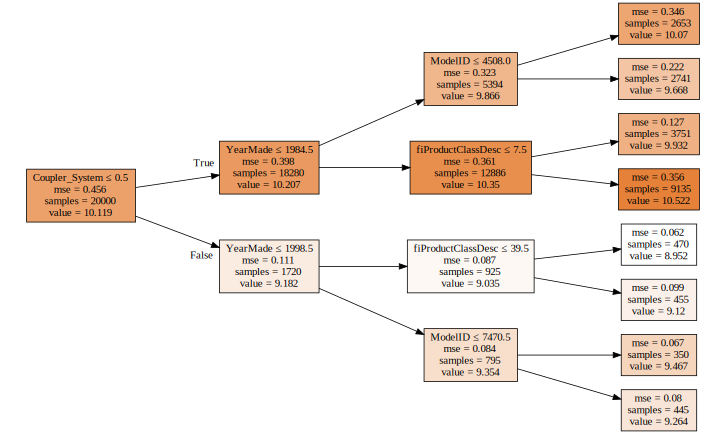

In [16]:
draw_tree(m.estimators_[0], df_trn, precision=3)

A tree is made of decision tree. Variable is chosen based on trying every varible + values(split point) of the varible and chosing the one that gives the best possible value.

In [16]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 472 ms, sys: 8 ms, total: 480 ms
Wall time: 576 ms
[4.351167857633658e-17, 0.499318422311411, 1.0, 0.554750794477057]


Our results are getting worse we need to start bagging of multiple trees to get more generalizable results.
<h3>Bagging</h3>


In [17]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/home/muoki/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11207072928281528, 0.3965451086966777, 0.9725878436655905, 0.7191766805327846]


by default estimator=10

In [18]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.10498, 11.15625,  9.07681,  9.43348, 11.15625, 11.15625, 11.15625, 11.15625, 11.15625,  9.68034]),
 10.42331198863713,
 9.104979856318357)

10 predictions of the 12000 validation set
mean of the prediction on one tree

In [19]:
preds.shape

(10, 12000)

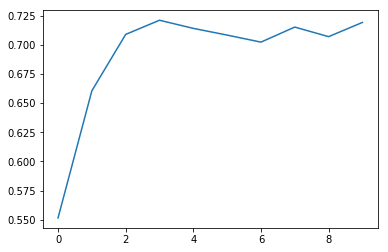

In [20]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

take first tree plot it then the first two plot etc up to 10 trees it then flatens 

In [21]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10233273675333453, 0.3760811149210907, 0.9771446444542773, 0.7474129822206446]


In [22]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09739387901720284, 0.37705073879482165, 0.9792975315945528, 0.7461088480016217]


In [23]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0946212790587922, 0.380162737022388, 0.9804594657829473, 0.7419005581065683]


adding trees to stops improving the model. We need to work on the features to improve the model.

<h3>Out of Bag</h3>
The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.
This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

In [24]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09723116412550357, 0.3638748009541418, 0.9793666485862343, 0.7635431304060836, 0.8530508237168813]


## Reducing over-fitting
### Subsampling

In [25]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [26]:
set_rf_samples(20000)

In [42]:
??set_rf_samples

selecting 20000 samples for each tree in the entire dataset 

In [27]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

/home/muoki/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 10.9 s, sys: 575 ms, total: 11.5 s
Wall time: 5.42 s
[0.23998482711031327, 0.2772218542809273, 0.8796343971725936, 0.862752986741204, 0.867036421819478]


In [28]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22699369129348088, 0.26200613643671056, 0.8923132176378384, 0.8774055244618052, 0.8808512383121353]


We are doing less overfitting and getting a better prediction

### Tree building parameters
We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [29]:
reset_rf_samples() 

In [30]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [31]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07831036182862208, 0.23834099394664426, 0.9871833865164114, 0.8985515382507789, 0.9086890247099475]


above is our base estimator as we are going to try changing the parameters.

In [32]:
t=m.estimators_[0].tree_

In [33]:
dectree_max_depth(t)

47

In [34]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1407153316468016, 0.23319437811031624, 0.958617410473521, 0.9028854893095996, 0.9070368518658877]


min_samples_leaf The minimum number of samples required to be at a leaf node.

In [35]:
?RandomForestRegressor

In [36]:
t=m.estimators_[0].tree_

In [37]:
dectree_max_depth(t)

38

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 7min 2s, sys: 1.78 s, total: 7min 3s
Wall time: 1min 50s
[0.11496627295122888, 0.23250325501906993, 0.9723766891396212, 0.9034602769330511, 0.9085756375636618]


In [39]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11919019514526528, 0.22850286325107894, 0.9703096109975735, 0.9067537732953466, 0.9115755186599184]


max_features The number of features to consider when looking for the best split